In [1]:
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [161]:
print(np.arange(10))

[0 1 2 3 4 5 6 7 8 9]


(2, 1000) (2, 1000)


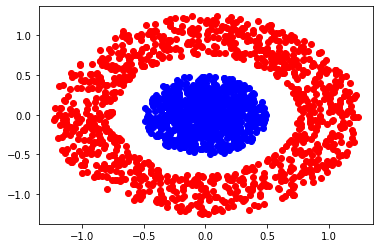

In [162]:
import random
from numpy import pi as PI
import math

blue_spiral = []
for _ in range(1000):
    theta = random.random() * 2 * PI
    r = (random.random()) / 2
    x = math.cos(theta) * r
    y = math.sin(theta) * r
    blue_spiral.append([x, y])

red_spiral = []
for _ in range(1000):
    theta = random.random() * 2 * PI
    r = (random.random()) / 2 + 0.75
    x = math.cos(theta) * r
    y = math.sin(theta) * r
    red_spiral.append([x, y])

blue_spiral = np.array(blue_spiral).T
red_spiral = np.array(red_spiral).T

print(blue_spiral.shape, red_spiral.shape)
plt.plot(*blue_spiral, "bo")
plt.plot(*red_spiral, "ro")

In [131]:
t = np.arange(2, 10, 0.0001) * 0.4
blue_spiral = np.array([np.cos(t), np.sin(t)]) * t
plt.grid()
plt.plot(*blue_spiral, "bo")

red_spiral = np.array([np.cos(t + np.pi), np.sin(t + np.pi)]) * t
plt.plot(*red_spiral, "ro")

In [5]:
blue_spiral.shape # (60x2  * 2x2)

(2, 800)

In [132]:
# preparing data for training
labels_blue = np.ones(len(blue_spiral.T)).reshape(-1, 1)
labels_red = np.zeros(len(blue_spiral.T)).reshape(-1, 1)

blue_spiral_l = np.concatenate((blue_spiral.T, labels_blue), axis=1)
red_spiral_l = np.concatenate((red_spiral.T, labels_red), axis=1)

data = np.concatenate((blue_spiral_l, red_spiral_l), axis=0)
data = torch.tensor(data, dtype=torch.float32)

In [133]:
# neural network

class Model(nn.Module):
    def __init__(self) -> None:
        super(Model, self).__init__()

        self.fc1 = nn.Linear(2, 2)
        self.fc2 = nn.Linear(2, 2)
        self.fc3 = nn.Linear(2, 2)
        self.fc4 = nn.Linear(2, 2)
        self.fc5 = nn.Linear(2, 1)

    def forward(self, input):
        outputs = [input]

        x = self.fc1(input)
        outputs.append(x)
        x = torch.tanh(x)
        outputs.append(x)

        x = self.fc2(x)
        outputs.append(x)
        x = torch.tanh(x)
        outputs.append(x)

        x = self.fc3(x)
        outputs.append(x)
        x = torch.tanh(x)
        outputs.append(x)

        x = self.fc4(x)
        outputs.append(x)
        x = torch.tanh(x)
        outputs.append(x)

        x = self.fc5(x)
        outputs.append(x)

        return x, outputs

In [134]:
model = Model().float()

optimizer = optim.Adam(model.parameters(), lr=1e-3)
model.requires_grad_(True)

Model(
  (fc1): Linear(in_features=2, out_features=2, bias=True)
  (fc2): Linear(in_features=2, out_features=2, bias=True)
  (fc3): Linear(in_features=2, out_features=2, bias=True)
  (fc4): Linear(in_features=2, out_features=2, bias=True)
  (fc5): Linear(in_features=2, out_features=1, bias=True)
)

In [135]:
for i in range(100000):
    x, labels = data[:, 0:2], data[:, 2].unsqueeze(1)
    pred,_ = model(x)
    loss = F.binary_cross_entropy_with_logits(pred, labels)

    if i % 1000 == 0:
        print(f"epoch: {i}, loss: {loss.item():.4f}")

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    

epoch: 0, loss: 0.7548
epoch: 1000, loss: 0.0970
epoch: 2000, loss: 0.0324
epoch: 3000, loss: 0.0156
epoch: 4000, loss: 0.0085
epoch: 5000, loss: 0.0049
epoch: 6000, loss: 0.0029
epoch: 7000, loss: 0.0018
epoch: 8000, loss: 0.0011
epoch: 9000, loss: 0.0007
epoch: 10000, loss: 0.0004
epoch: 11000, loss: 0.0003
epoch: 12000, loss: 0.0002
epoch: 13000, loss: 0.0001
epoch: 14000, loss: 0.0001
epoch: 15000, loss: 0.0000


KeyboardInterrupt: 

In [137]:
torch.save(model.state_dict(), "saved_models/separating_spirals2d_tanh")

In [113]:
weights = [parameter for parameter in model.state_dict().values() if len(parameter.shape) != 1]
biases = [parameter for parameter in model.state_dict().values() if len(parameter.shape) == 1]

In [114]:
biases

[tensor([-0.0235,  1.2917]),
 tensor([-1.5779, -0.1957]),
 tensor([1.0228, 1.0179]),
 tensor([ 0.0248, -0.0104]),
 tensor([0.0002])]

In [121]:
def leaky_relu_inv(x, negative_slope=0.01):
    return torch.minimum(1/negative_slope*x, x)

Exception ignored in: <function TransformNode.set_children.<locals>.<lambda> at 0x2e447f4c0>
Traceback (most recent call last):
  File "/Users/mujtabaalajmi/opt/miniconda3/envs/manim/lib/python3.9/site-packages/matplotlib/transforms.py", line 222, in <lambda>
    self, lambda _, pop=child._parents.pop, k=id(self): pop(k))
KeyboardInterrupt: 


KeyboardInterrupt: 

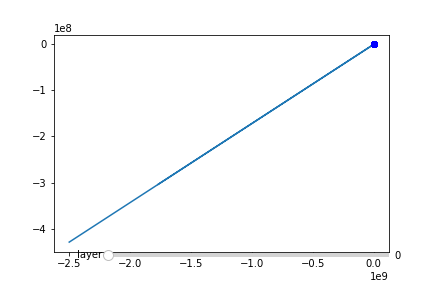

In [136]:
from matplotlib.widgets import Slider
%matplotlib widget

x, labels = data[:, 0:2], data[:, 2].detach().numpy()
_, hidden_out = model(x)


# TRY TO GET THE REVERSE TRANSFORMATION TO WORK!
w = list(model.parameters())[-2].detach().squeeze(0)
b = list(model.parameters())[-1].detach().squeeze(0)
x = np.arange(-100, 100, 0.001)
y = -w[0]/w[1] * x - b / w[1]

line = np.concatenate((x.reshape(-1, 1), y.reshape(-1, 1)), axis=1)


bound = torch.tensor(line).float().detach()
bounds = [bound]

W = list(reversed(list(model.parameters())))[2:]
bound = leaky_relu_inv(bound)
bounds.append(bound)
bound -= W[0]
bound = bound @ torch.inverse(W[1])
bounds.append(bound)
bound = leaky_relu_inv(bound)
bounds.append(bound)
bound -= W[2]
bound = bound @ torch.inverse(W[3])
bounds.append(bound)
bound = leaky_relu_inv(bound)
bounds.append(bound)
bound -= W[4]
bound = bound @ torch.inverse(W[5])
bounds.append(bound)
# something goes wrong here?
bound = leaky_relu_inv(bound)
bounds.append(bound)
bound -= W[6]
bound = bound @ torch.inverse(W[7])
bounds.append(bound)
bounds = list(reversed(bounds))
ax = plt.axes()



ax_layer = plt.axes([0.25, 0.1, 0.65, 0.03])
layer_slider = Slider(ax_layer, label="layer", valmin=0, valmax=len(hidden_out) - 2, valstep=1)

def update_graph(val):
    ax.clear()
    layer = hidden_out[layer_slider.val].detach().numpy()
    ax.plot(*bounds[layer_slider.val].detach().numpy().T)

    for h_out, label in zip(layer, labels):
        color = "ro" if label == 0 else "bo"
        ax.plot(*h_out, color)

    ax.set_ylim([-5, 5])
    ax.set_xlim([-5,5])
    
update_graph(0)
layer_slider.on_changed(update_graph)

plt.show()